## Import Library

In [55]:
# Image Processing and Manipulation
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
import math
import os

# Data Handling and Analysis
import pandas as pd
from scipy.stats import skew, kurtosis

# Feature Extraction
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

# Utilities and Visualization
from tqdm import tqdm
import seaborn as sns

# Machine Learning - Model Building and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import Data and Library

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Dataset

In [57]:
import zipfile

zip_path = "/content/drive/MyDrive/Dataset.zip"

extract_dir = "tb_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Selesai extract ke:", extract_dir)


Selesai extract ke: tb_dataset


# Sample Dataset

In [58]:
def show_pair(img_before, img_after, title_before="Before", title_after="After"):
    plt.figure(figsize=(10,5))

    # Kiri
    plt.subplot(1,2,1)
    plt.imshow(img_before, cmap='gray', vmin=0, vmax=255)
    plt.title(title_before)
    plt.axis("off")

    # Kanan
    plt.subplot(1,2,2)
    plt.imshow(img_after, cmap='gray', vmin=0, vmax=255)
    plt.title(title_after)
    plt.axis("off")

    plt.show()


In [59]:
# Upload Dataset

import glob

ZIP_PATH = "/content/drive/MyDrive/Dataset.zip"
EXTRACT_DIR = "tb_dataset"

# Unzip
os.makedirs(EXTRACT_DIR, exist_ok=True)
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_DIR)
    print("Extracted zip to", EXTRACT_DIR)
else:
    print("ZIP_PATH not found. Jika file sudah di-extract, set EXTRACT_DIR ke folder dataset yang benar.")
    # list subfolders if exists
if os.path.exists(EXTRACT_DIR):
    for root, dirs, files in os.walk(EXTRACT_DIR):
        print(root, "->", len(files), "files")
        break

# Contoh: temukan beberapa file gambar untuk sampel
img_list = glob.glob(os.path.join(EXTRACT_DIR, '**', '*.png'), recursive=True) + \
           glob.glob(os.path.join(EXTRACT_DIR, '**', '*.jpg'), recursive=True) + \
           glob.glob(os.path.join(EXTRACT_DIR, '**', '*.jpeg'), recursive=True)
print("Total images found (recursive):", len(img_list))
# show first sample path
if img_list:
    print("Contoh file:", img_list[0])
else:
    print("Tidak menemukan gambar. Periksa struktur dataset.")


Extracted zip to tb_dataset
tb_dataset -> 0 files
Total images found (recursive): 7000
Contoh file: tb_dataset/Dataset/Tuberculosis/TB (2501).png


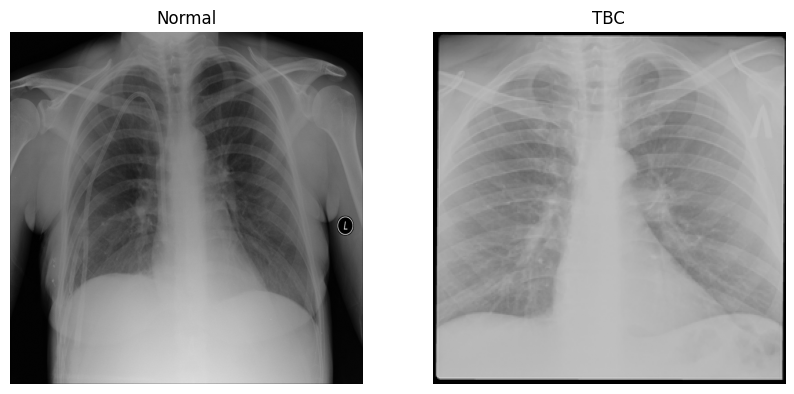

In [60]:
img_normal_path = "/content/tb_dataset/Dataset/Normal/Normal (1).jpg"
img_tbc_path = "/content/tb_dataset/Dataset/Tuberculosis/TB (10).png"

# Read the images using OpenCV
import cv2
img_normal = cv2.imread(img_normal_path, cv2.IMREAD_GRAYSCALE)
img_tbc = cv2.imread(img_tbc_path, cv2.IMREAD_GRAYSCALE)

show_pair(img_normal, img_tbc, "Normal", "TBC")

# Enhancement

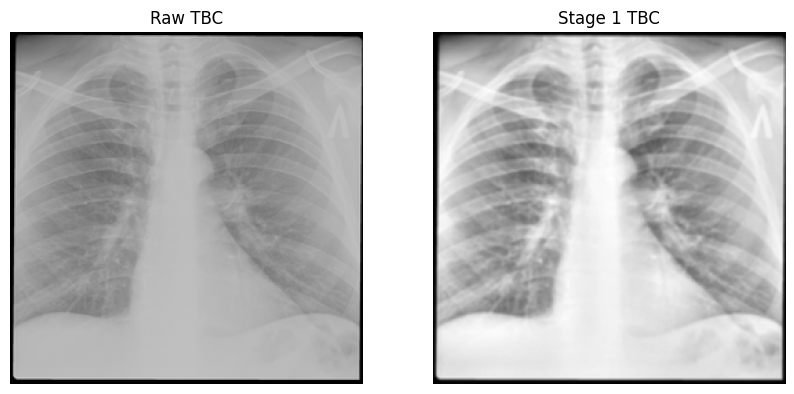

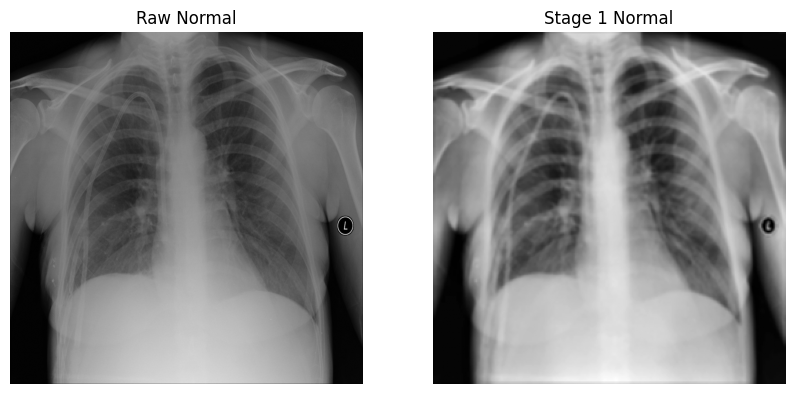

Output Stage 1: Normalize + Bilateral + CLAHE


In [61]:
# ============================================
# 2 — STAGE 1: PREPROCESSING
# ============================================

def stage1_preprocessing(img):
    # Img input harus grayscale atau read as grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize preserve aspect ratio → target 256
    h, w = img.shape
    target = 256
    scale = target / max(h, w)

    new_h, new_w = int(h * scale), int(w * scale)
    img_small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad ke 256x256 (centered)
    padded = np.zeros((target, target), dtype=np.uint8)
    y_off = (target - new_h) // 2
    x_off = (target - new_w) // 2
    padded[y_off:y_off+new_h, x_off:x_off+new_w] = img_small

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
    padded = clahe.apply(padded)

    # Gaussian blur ringan
    padded = cv2.GaussianBlur(padded, (3,3), 0)

    # Normalize
    padded = cv2.normalize(padded, None, 0, 255, cv2.NORM_MINMAX)

    return padded


# --- EXEC ---
tbc_enhanced = stage1_preprocessing(img_tbc)
normal_enhanced = stage1_preprocessing(img_normal)

show_pair(img_tbc, tbc_enhanced, "Raw TBC", "Stage 1 TBC")
show_pair(img_normal, normal_enhanced, "Raw Normal", "Stage 1 Normal")

print("Output Stage 1: Normalize + Bilateral + CLAHE")


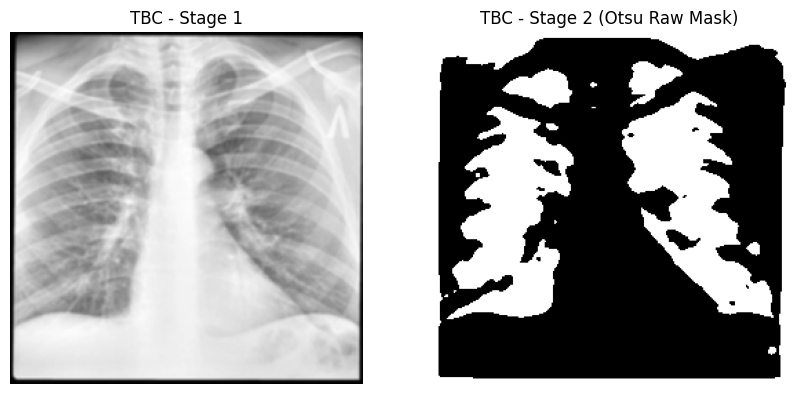

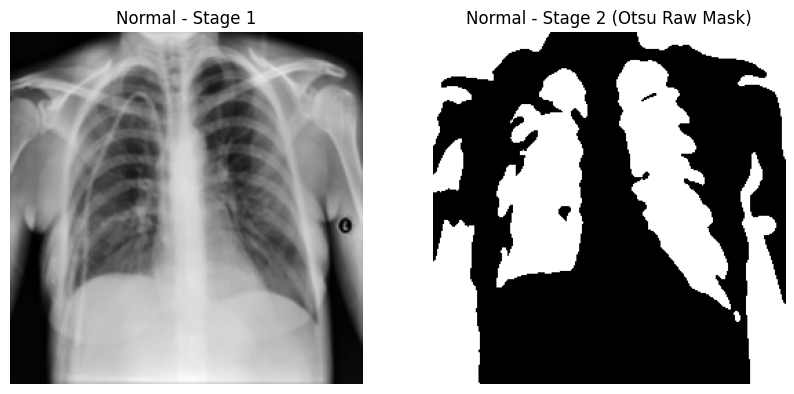

Output Tahap 2: OTSU Threshold (Paru = Putih).


In [62]:
# ============================================
# 3 — STAGE 2: OTSU + FALLBACK
# ============================================

def stage2_threshold(img):
    # blur ringan
    blur = cv2.GaussianBlur(img, (7,7), 0)

    # Otsu binary INV → paru putih
    _, otsu = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # kalau mask terlalu kecil → fallback ke Otsu non-inv
    if np.count_nonzero(otsu) < 2000:
        _, alt = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        alt = cv2.bitwise_not(alt)

        # pilih yang lebih besar
        if np.count_nonzero(alt) > np.count_nonzero(otsu):
            return alt

    return otsu

# --- EKSEKUSI ---
if 'tbc_enhanced' in globals():
    tbc_seg_raw = stage2_threshold(tbc_enhanced)
    normal_seg_raw = stage2_threshold(normal_enhanced)

    # Tampilkan hasil
    show_pair(tbc_enhanced, tbc_seg_raw, "TBC - Stage 1", "TBC - Stage 2 (Otsu Raw Mask)")
    show_pair(normal_enhanced, normal_seg_raw, "Normal - Stage 1", "Normal - Stage 2 (Otsu Raw Mask)")

    print("Output Tahap 2: OTSU Threshold (Paru = Putih).")


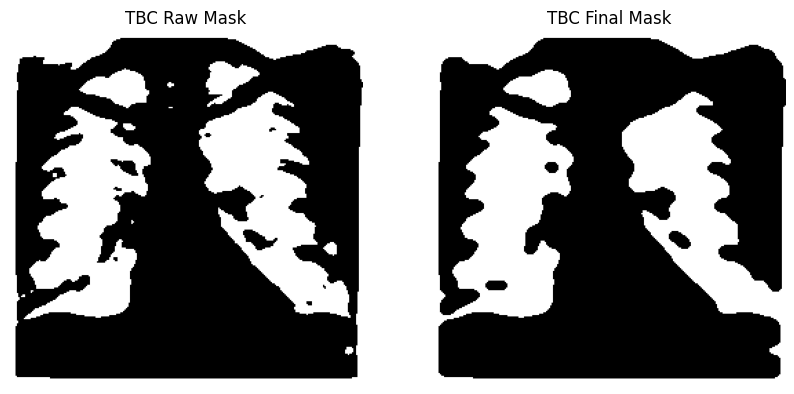

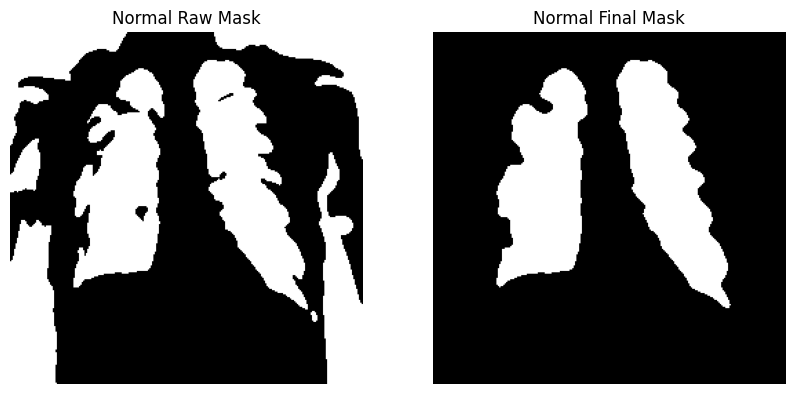

In [63]:
# ============================================
# 4 — STAGE 3: MORPHOLOGY CLEAN
# ============================================

def _odd(x):
    x = int(max(3, round(x)))
    return x if (x % 2) == 1 else x + 1

def stage3_clean(mask):
    """
    Clean binary mask (0/255). Returns cleaned mask that keeps the
    two most-likely lung components (or one if only one valid).
    """
    # safety: if mask nearly empty, return as-is
    if np.count_nonzero(mask) < 800:
        return mask

    H, W = mask.shape
    area_img = H * W

    # dynamic kernel sizes proportional to image dimension
    k_close = _odd(min(H, W) * 0.02)    # ~2% of min dim
    k_open  = _odd(min(H, W) * 0.01)    # ~1% of min dim

    k_close = (k_close, k_close)
    k_open  = (k_open, k_open)

    # apply morphology (close then open) - mild iterations
    k_close_el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, k_close)
    k_open_el  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, k_open)

    cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close_el, iterations=2)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN,  k_open_el, iterations=1)

    # label connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned.astype(np.uint8), connectivity=8)

    candidates = []
    eps = 1e-6

    # thresholds (fractions of image area) - more tolerant
    min_area_frac = 0.005   # at least 0.5% of image
    max_area_frac = 0.45    # at most 45% (avoid body shadow)

    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area <= 0:
            continue

        # basic area filter
        if area < min_area_frac * area_img:
            continue
        if area > max_area_frac * area_img:
            continue

        # aspect ratio check (lungs often taller but not always) - allow wider ones too
        aspect = h / (w + eps)

        # centroid x (center of bbox)
        cx = x + w / 2.0

        # reject components that are extremely peripheral horizontally
        if cx < W * 0.05 or cx > W * 0.95:
            continue

        # score by area but keep aspect info
        # prefer larger components and those roughly vertically elongated, but not strictly
        aspect_score = min(aspect, 2.0)  # cap aspect contribution
        score = area * (0.8 + 0.4 * (aspect_score / 2.0))  # area primary, aspect secondary

        candidates.append((score, area, i))

    # if nothing passed, fallback to mild processing (return cleaned)
    if len(candidates) == 0:
        # small safety: remove tiny specks by area-thresholding on cleaned
        fallback = np.zeros_like(mask)
        for i in range(1, num):
            x, y, w, h, area = stats[i]
            if area >= min_area_frac * area_img:
                fallback[labels == i] = 255
        if np.count_nonzero(fallback) == 0:
            return cleaned
        return fallback

    # choose top 2 candidates by score (there should be 2 lungs)
    candidates = sorted(candidates, key=lambda x: x[0], reverse=True)
    chosen_labels = [candidates[0][2]]
    if len(candidates) >= 2:
        chosen_labels.append(candidates[1][2])

    # build final mask with chosen labels
    final = np.zeros_like(mask)
    for lab in chosen_labels:
        final[labels == lab] = 255

    # small median blur to smooth boundaries and remove speckles
    final = cv2.medianBlur(final.astype(np.uint8), 5)

    return final


# -------------------------
# EXEC
# -------------------------
tbc_final    = stage3_clean(tbc_seg_raw)
normal_final = stage3_clean(normal_seg_raw)

# show_pair must exist in notebook
show_pair(tbc_seg_raw,  tbc_final,      "TBC Raw Mask",    "TBC Final Mask")
show_pair(normal_seg_raw, normal_final, "Normal Raw Mask", "Normal Final Mask")


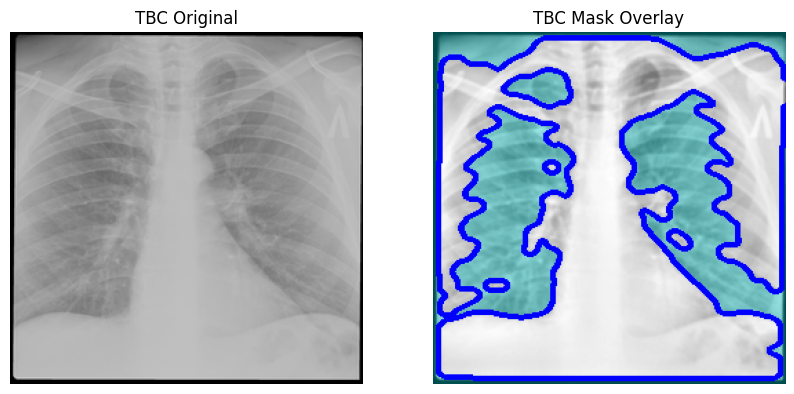

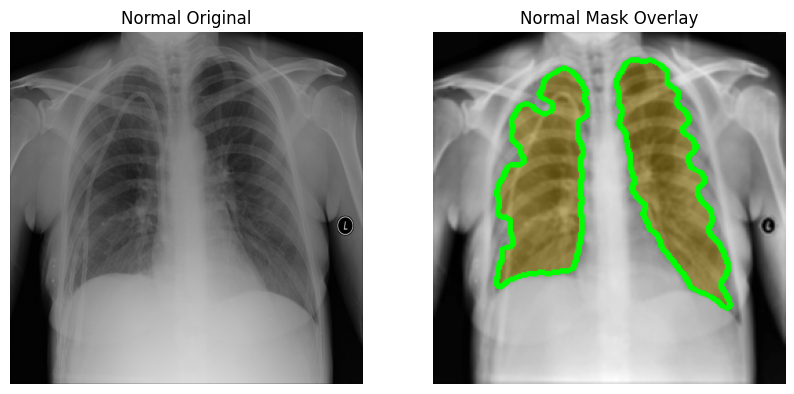

In [64]:
# ============================================
# 5 — STAGE 3.5: Mask Overlay
# ============================================


def colored_border(mask, color=(0,0,255), ksize=5):
    mask_bin = (mask > 0).astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    border = cv2.morphologyEx(mask_bin, cv2.MORPH_GRADIENT, k)

    border_color = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    border_color[border > 0] = color
    return border_color

def colored_mask(mask, color=(0,255,255), alpha=0.35):
    # warna mask
    mask_color = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    mask_color[mask > 0] = color

    return mask_color, alpha

def overlay_on_image(img, mask_color, alpha, border_color):
    # mask overlay
    mask_indices = (mask_color.sum(axis=2) > 0)
    overlay = img.copy()
    overlay[mask_indices] = (
        (1 - alpha) * img[mask_indices] +
        alpha * mask_color[mask_indices]
    ).astype(np.uint8)

    # border override
    border_idx = (border_color.sum(axis=2) > 0)
    overlay[border_idx] = border_color[border_idx]

    return overlay

# Convert the 512x512 enhanced grayscale images to 3-channel for overlaying colored masks.
tbc_base_for_overlay = cv2.cvtColor(tbc_enhanced, cv2.COLOR_GRAY2BGR)
normal_base_for_overlay = cv2.cvtColor(normal_enhanced, cv2.COLOR_GRAY2BGR)

# warna: BGR
tbc_border  = colored_border(tbc_final,  color=(0,0,255))      # merah
tbc_maskcol, talpha = colored_mask(tbc_final,  color=(0,255,255), alpha=0.30)

normal_border  = colored_border(normal_final, color=(0,255,0)) # hijau
normal_maskcol, nalpha = colored_mask(normal_final, color=(255,200,0), alpha=0.30)

tbc_overlay = overlay_on_image(tbc_base_for_overlay, tbc_maskcol, talpha, tbc_border)
normal_overlay = overlay_on_image(normal_base_for_overlay, normal_maskcol, nalpha, normal_border)

# Use the original (grayscale) images for comparison in show_pair.
show_pair(img_tbc, tbc_overlay,
          "TBC Original", "TBC Mask Overlay")

show_pair(img_normal, normal_overlay,
          "Normal Original", "Normal Mask Overlay")

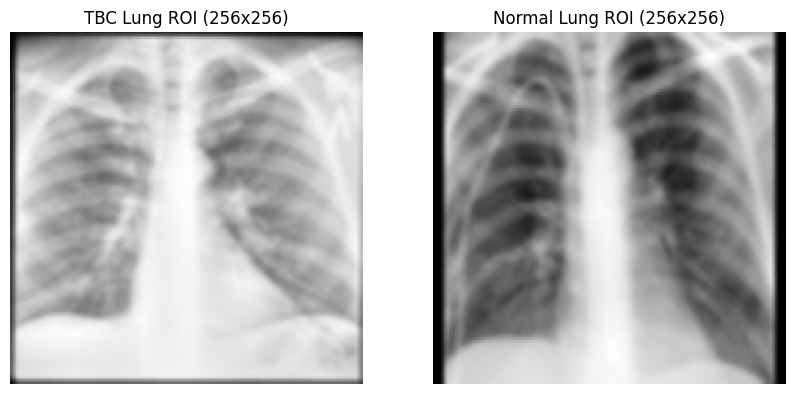

In [65]:
# ============================================
# 6 — STAGE 4: ROI 256x256
# ============================================

def stage4_apply_mask(img_preprocessed, mask_clean):
    ys, xs = np.where(mask_clean == 255)
    if len(xs) == 0:
        return None

    # Ambil bounding box paru
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    roi = img_preprocessed[y1:y2, x1:x2]

    # Resize with preserved aspect ratio → target = 128
    target = 128
    h, w = roi.shape
    scale = target / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)

    resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to 128×128
    padded = np.zeros((target, target), dtype=np.uint8)
    y_off = (target - new_h) // 2
    x_off = (target - new_w) // 2
    padded[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # final smoothing
    padded = cv2.GaussianBlur(padded, (3,3), 0)
    padded = cv2.normalize(padded, None, 0,255, cv2.NORM_MINMAX)

    return padded


tbc_roi    = stage4_apply_mask(tbc_enhanced, tbc_final)
normal_roi = stage4_apply_mask(normal_enhanced, normal_final)

show_pair(tbc_roi, normal_roi,
          "TBC Lung ROI (256x256)",
          "Normal Lung ROI (256x256)")



# Feature

In [66]:
# ============================================
# 7 — EKSTRAKSI FITUR
# ============================================

def extract_features(img):
    if img is None:
        return np.zeros(120,)

    pixels = img[img > 0].ravel()
    if len(pixels) == 0:
        return np.zeros(120,)

    # Statistik dasar
    stats_feat = [
        np.mean(pixels),
        np.std(pixels),
        np.min(pixels),
        np.max(pixels),
        shannon_entropy(pixels),
        skew(pixels),
        kurtosis(pixels)
    ]

    # Histogram 16 bin
    hist, _ = np.histogram(pixels, bins=16, range=(0,255), density=True)

    # HOG
    hog_feat = hog(
        img,
        orientations=9,
        pixels_per_cell=(64,64),
        cells_per_block=(1,1),
        block_norm='L2-Hys'
    )

    # Final fitur
    return np.hstack([stats_feat, hist, hog_feat])


In [67]:
# ============================================
# 8 — BATCH EKSTRAKSI FITUR
# ============================================

folder_normal = "/content/tb_dataset/Dataset/Normal"
folder_tbc    = "/content/tb_dataset/Dataset/Tuberculosis"

max_samples = 3500

features = []
labels   = []

# --------------------------------------------
# Fungsi proses satu gambar
# --------------------------------------------
def process_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img1 = stage1_preprocessing(img)
    m1   = stage2_threshold(img1)
    m2   = stage3_clean(m1)
    roi  = stage4_apply_mask(img1, m2)

    return extract_features(roi)

# --------------------------------------------
# Loader dengan LIMIT
# --------------------------------------------
def load_folder(folder, label, max_samples):
    count = 0
    print(f"\n============================================")
    print(f"  MEMPROSES FOLDER: {folder}")
    print(f"  LABEL: {label} (LIMIT = {max_samples})")
    print(f"============================================")

    for fname in tqdm(sorted(os.listdir(folder))):
        if count >= max_samples:
            break

        if not fname.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif")):
            continue

        fpath = os.path.join(folder, fname)
        feats = process_image(fpath)

        if feats is not None:
            features.append(feats)
            labels.append(label)
            count += 1

    print(f"  -> Total diekstrak: {count} sampel")

# --------------------------------------------
# Eksekusi batch untuk NORMAL & TBC
# --------------------------------------------
load_folder(folder_normal, 0, max_samples)
load_folder(folder_tbc, 1, max_samples)

# Array final
X = np.array(features)
y = np.array(labels)

print("\n============================================")
print("DATASET FINAL:", X.shape)
print("============================================")



  MEMPROSES FOLDER: /content/tb_dataset/Dataset/Normal
  LABEL: 0 (LIMIT = 3500)


100%|██████████| 3500/3500 [01:03<00:00, 55.34it/s]


  -> Total diekstrak: 3500 sampel

  MEMPROSES FOLDER: /content/tb_dataset/Dataset/Tuberculosis
  LABEL: 1 (LIMIT = 3500)


100%|██████████| 3500/3500 [01:00<00:00, 57.52it/s]

  -> Total diekstrak: 3500 sampel

DATASET FINAL: (7000, 59)


In [68]:
# ============================================
# 9 — SAVE FEATURES
# ============================================

def build_feature_names(sample_img):
    # Ambil fitur dari satu gambar sampel
    feat = extract_features(sample_img)
    total_len = len(feat)

    stats_len = 7
    hist_len = 16

    hog_len = total_len - stats_len - hist_len
    if hog_len <= 0:
        raise ValueError("Jumlah fitur tidak masuk akal. Cek ekstraksi HOG kamu.")

    # Nama statistik
    stats_names = [
        "stat_mean", "stat_std", "stat_min", "stat_max",
        "stat_entropy", "stat_skew", "stat_kurtosis"
    ]

    # Nama histogram
    hist_names = [f"hist_bin_{i}" for i in range(hist_len)]

    # Nama HOG
    hog_names = [f"hog_{i}" for i in range(hog_len)]

    return stats_names + hist_names + hog_names


sample_feat_img = tbc_roi if tbc_roi is not None else normal_roi

col_names = build_feature_names(sample_feat_img)

df = pd.DataFrame(X, columns=col_names)
df["Label"] = y

df.to_csv("dataset_pcd_features.csv", index=False)

print("DF shape:", df.shape)
print("Fitur:", len(col_names))



DF shape: (7000, 60)
Fitur: 59


## Feature Extraction Result

In [69]:
list(df.columns)


['stat_mean',
 'stat_std',
 'stat_min',
 'stat_max',
 'stat_entropy',
 'stat_skew',
 'stat_kurtosis',
 'hist_bin_0',
 'hist_bin_1',
 'hist_bin_2',
 'hist_bin_3',
 'hist_bin_4',
 'hist_bin_5',
 'hist_bin_6',
 'hist_bin_7',
 'hist_bin_8',
 'hist_bin_9',
 'hist_bin_10',
 'hist_bin_11',
 'hist_bin_12',
 'hist_bin_13',
 'hist_bin_14',
 'hist_bin_15',
 'hog_0',
 'hog_1',
 'hog_2',
 'hog_3',
 'hog_4',
 'hog_5',
 'hog_6',
 'hog_7',
 'hog_8',
 'hog_9',
 'hog_10',
 'hog_11',
 'hog_12',
 'hog_13',
 'hog_14',
 'hog_15',
 'hog_16',
 'hog_17',
 'hog_18',
 'hog_19',
 'hog_20',
 'hog_21',
 'hog_22',
 'hog_23',
 'hog_24',
 'hog_25',
 'hog_26',
 'hog_27',
 'hog_28',
 'hog_29',
 'hog_30',
 'hog_31',
 'hog_32',
 'hog_33',
 'hog_34',
 'hog_35',
 'Label']

# Modelling and Evaluation

Melatih Random Forest...
Melatih Gradient Boosting...
Melatih SVM...

========== HASIL RANDOM FOREST ==========
Akurasi: 87.79%
              precision    recall  f1-score   support

      Normal       0.86      0.91      0.88       711
         TBC       0.90      0.85      0.87       689

    accuracy                           0.88      1400
   macro avg       0.88      0.88      0.88      1400
weighted avg       0.88      0.88      0.88      1400



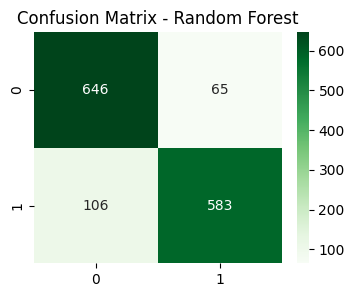


========== HASIL GRADIENT BOOSTING ==========
Akurasi: 89.57%
              precision    recall  f1-score   support

      Normal       0.89      0.91      0.90       711
         TBC       0.90      0.88      0.89       689

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400



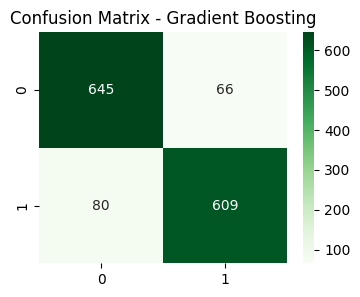


========== HASIL SVM ==========
Akurasi: 88.93%
              precision    recall  f1-score   support

      Normal       0.87      0.91      0.89       711
         TBC       0.91      0.87      0.88       689

    accuracy                           0.89      1400
   macro avg       0.89      0.89      0.89      1400
weighted avg       0.89      0.89      0.89      1400



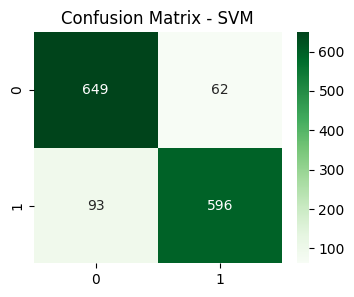


TOP 20 FITUR PALING BERPENGARUH (SVM):
1. stat_kurtosis	(0.1590) (Stat)
2. hist_bin_5	(0.0811) (Hist)
3. hist_bin_14	(0.0653) (Hist)
4. stat_entropy	(0.0519) (Stat)
5. hist_bin_15	(0.0458) (Hist)
6. stat_std	(0.0415) (Stat)
7. hist_bin_6	(0.0334) (Hist)
8. hist_bin_2	(0.0319) (Hist)
9. hist_bin_13	(0.0316) (Hist)
10. hist_bin_9	(0.0315) (Hist)
11. hog_31	(0.0306) (HOG)
12. hist_bin_11	(0.0259) (Hist)
13. hog_34	(0.0212) (HOG)
14. hist_bin_7	(0.0194) (Hist)
15. hog_19	(0.0193) (HOG)
16. hist_bin_1	(0.0187) (Hist)
17. hist_bin_3	(0.0182) (Hist)
18. hog_20	(0.0181) (HOG)
19. hist_bin_0	(0.0174) (Hist)
20. hog_4	(0.0130) (HOG)


In [70]:

# df = pd.read_csv('dataset_pcd_featues.csv')

df.fillna(0, inplace=True)

# Pisahkan Fitur & Label
X = df.drop('Label', axis=1)
y = df['Label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Wajib untuk SVM dan HOG yang nilainya kecil)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- MODEL 1: RANDOM FOREST ---
print("Melatih Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- MODEL 2: GRADIENT BOOSTING ---
print("Melatih Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# --- MODEL 3: SVM ---
print("Melatih SVM...")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# --- EVALUASI ---
def show_result(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{'='*10} HASIL {model_name.upper()} {'='*10}")
    print(f"Akurasi: {acc*100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'TBC']))

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

show_result("Random Forest", y_test, y_pred_rf)
show_result("Gradient Boosting", y_test, y_pred_gb)
show_result("SVM", y_test, y_pred_svm)

# --- FEATURE IMPORTANCE (Cek apakah HOG/LBP berguna?) ---
# Using Gradient Boosting model for feature importances
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Tentukan indeks akhir berdasarkan col_names
stats_end = 7
hist_end = stats_end + 16
hog_end = len(col_names)  # sisanya HOG

print("\nTOP 20 FITUR PALING BERPENGARUH (SVM):")
for i in range(20):
    feature_index = indices[i]
    fitur = col_names[feature_index]
    skor = importances[feature_index]

    # Deteksi kategori
    if feature_index < stats_end:
        tanda = "(Stat)"
    elif feature_index < hist_end:
        tanda = "(Hist)"
    elif feature_index < hog_end:
        tanda = "(HOG)"
    else:
        tanda = ""

    print(f"{i+1}. {fitur}\t({skor:.4f}) {tanda}")


🔧 Hyperparameter Tuning SVM (Custom Random Search)

Iter 01: C=0.022064, gamma=0.131252 -> CV Acc=0.5332
Iter 02: C=0.001889, gamma=0.000833 -> CV Acc=0.5020
Iter 03: C=9.949630, gamma=0.001564 -> CV Acc=0.8423
Iter 04: C=365.128470, gamma=0.878447 -> CV Acc=0.6330
Iter 05: C=0.162847, gamma=0.005299 -> CV Acc=0.8077
Iter 06: C=260.095869, gamma=0.084089 -> CV Acc=0.8795
Iter 07: C=0.263157, gamma=0.001572 -> CV Acc=0.7725
Iter 08: C=0.028421, gamma=1.327585 -> CV Acc=0.5020
Iter 09: C=71.259481, gamma=6.353788 -> CV Acc=0.5055
Iter 10: C=11.777966, gamma=0.020454 -> CV Acc=0.9014
Iter 11: C=0.204291, gamma=0.000517 -> CV Acc=0.7132
Iter 12: C=0.022872, gamma=0.000516 -> CV Acc=0.6873
Iter 13: C=0.005886, gamma=0.340670 -> CV Acc=0.5020
Iter 14: C=0.002432, gamma=0.352542 -> CV Acc=0.5020
Iter 15: C=0.219247, gamma=0.000445 -> CV Acc=0.7098
Iter 16: C=0.023012, gamma=0.000268 -> CV Acc=0.5020
Iter 17: C=455.092703, gamma=3.828071 -> CV Acc=0.5061
Iter 18: C=37.206006, gamma=1.219952 ->

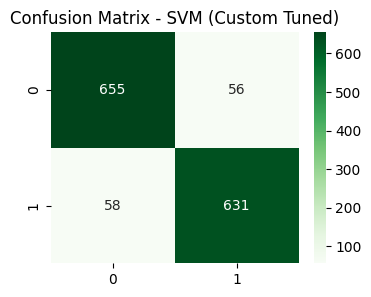

In [77]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
import numpy as np
from scipy.stats import reciprocal

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# FIX: sampling harus benar-benar random, jangan pakai random_state
def sample_recip(low, high):
    return reciprocal(low, high).rvs()

n_iter = 30
best_score = -1
best_params = None
best_model = None

print("🔧 Hyperparameter Tuning SVM (Custom Random Search)\n")

for i in range(1, n_iter + 1):
    # Ambil sample random (beneran random)
    C_val = sample_recip(1e-3, 1e3)
    gamma_val = sample_recip(1e-4, 1e1)

    model = SVC(
        C=C_val,
        gamma=gamma_val,
        kernel="rbf",
        probability=True,
        random_state=42
    )

    # CV evaluation
    scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv_strategy,
        scoring="accuracy",
        n_jobs=-1
    )
    mean_score = scores.mean()

    # Log tiap iterasi (INI YANG KAMU MAU)
    print(f"Iter {i:02d}: C={C_val:.6f}, gamma={gamma_val:.6f} -> CV Acc={mean_score:.4f}")

    # Simpan best model
    if mean_score > best_score:
        best_score = mean_score
        best_params = (C_val, gamma_val)
        best_model = model.fit(X_train_scaled, y_train)

# ---------------------------------------------------------
# HASIL AKHIR
# ---------------------------------------------------------
print("\n🏆 Best Hyperparameters:")
print(f"C={best_params[0]:.6f}, gamma={best_params[1]:.6f}")
print(f"Best CV Accuracy: {best_score:.4f}")

# Evaluate on test
y_pred_best_svm = best_model.predict(X_test_scaled)
show_result("SVM (Custom Tuned)", y_test, y_pred_best_svm)


In [72]:
import pandas as pd

# Ambil hasil tuning
results = pd.DataFrame(tuner.cv_results_)

# Keep kolom yang berguna
cols_to_show = [
    'params',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

print("\nHASIL DETAIL SEMUA PARAMETER TUNING (DIURUTKAN DARI TERBAIK):\n")

# Urutkan berdasarkan performa
results_sorted = results[cols_to_show].sort_values(by='rank_test_score')

pd.set_option('display.max_rows', None)  # Tampilkan semua baris
print(results_sorted)



HASIL DETAIL SEMUA PARAMETER TUNING (DIURUTKAN DARI TERBAIK):

                                               params  mean_test_score  \
19  {'C': 12.746711578215052, 'gamma': 0.015876781...         0.901786   
1   {'C': 24.658329458549105, 'gamma': 0.098467388...         0.871964   
6   {'C': 98.77700294007911, 'gamma': 0.0011526449...         0.867857   
15  {'C': 4.418441521199722, 'gamma': 0.0007122305...         0.811786   
9   {'C': 0.3905441275210791, 'gamma': 0.002858549...         0.809464   
10  {'C': 4.689400963537685, 'gamma': 0.0004982752...         0.803393   
24  {'C': 1.9066091638188458, 'gamma': 0.000839986...         0.801786   
23  {'C': 0.07417652034871831, 'gamma': 0.03984190...         0.798750   
8   {'C': 0.06690421166498801, 'gamma': 0.04205156...         0.794107   
14  {'C': 3.584985580340472, 'gamma': 0.0001707072...         0.780536   
11  {'C': 0.05660670699258887, 'gamma': 0.00678905...         0.773571   
13  {'C': 0.01577766363058246, 'gamma': 0.037253

In [73]:
# === SAVE MODEL SVM + SCALER ===
import joblib

# Simpan model dan scaler sekaligus
joblib.dump({
    'svm_model': svm_model,
    'scaler': scaler
}, 'svm_lung_tbc_model.pkl')

print("Model SVM dan scaler berhasil disimpan sebagai svm_lung_tbc_model.pkl")


Model SVM dan scaler berhasil disimpan sebagai svm_lung_tbc_model.pkl


Model berhasil diload.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


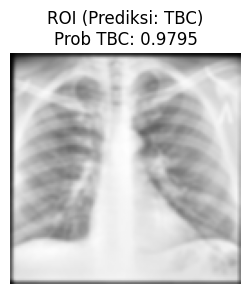

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


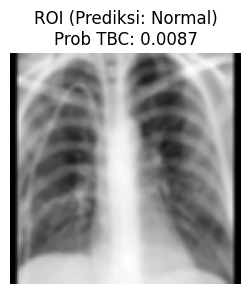

In [74]:
# === TESTING: TAMPILKAN ROI + PREDIKSI MODEL ===
import joblib
import cv2
import numpy as np

# Load model + scaler
saved = joblib.load('svm_lung_tbc_model.pkl')
svm_loaded = saved['svm_model']
scaler_loaded = saved['scaler']

print("Model berhasil diload.")

def predict_image_with_roi(img_preprocessed, mask_clean):
    # 1. Generate ROI
    roi = stage4_apply_mask(img_preprocessed, mask_clean)
    if roi is None:
        print("ROI tidak ditemukan.")
        return None

    # 2. Ekstraksi fitur (87 fitur)
    fitur = extract_features(roi)
    fitur = np.array(fitur).reshape(1, -1)

    # 3. Scaling
    fitur_scaled = scaler_loaded.transform(fitur)

    # 4. Prediksi model
    pred = svm_loaded.predict(fitur_scaled)[0]
    proba = svm_loaded.predict_proba(fitur_scaled)[0]

    # 5. Display ROI
    plt.figure(figsize=(3,3))
    plt.imshow(roi, cmap='gray')
    plt.title(f"ROI (Prediksi: {'TBC' if pred == 1 else 'Normal'})\nProb TBC: {proba[1]:.4f}")
    plt.axis('off')
    plt.show()

    return pred, proba


# === CONTOH PEMAKAIAN ===
# Misalnya kamu punya gambar enhanced + mask hasil segmentasi
pred_tbc, proba_tbc = predict_image_with_roi(tbc_enhanced, tbc_final)
pred_normal, proba_normal = predict_image_with_roi(normal_enhanced, normal_final)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


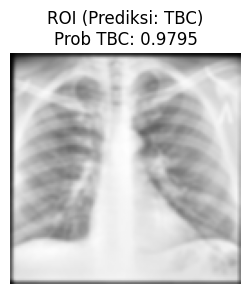

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


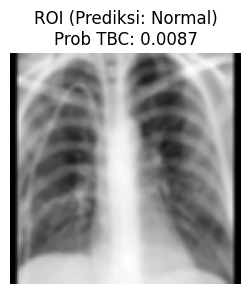

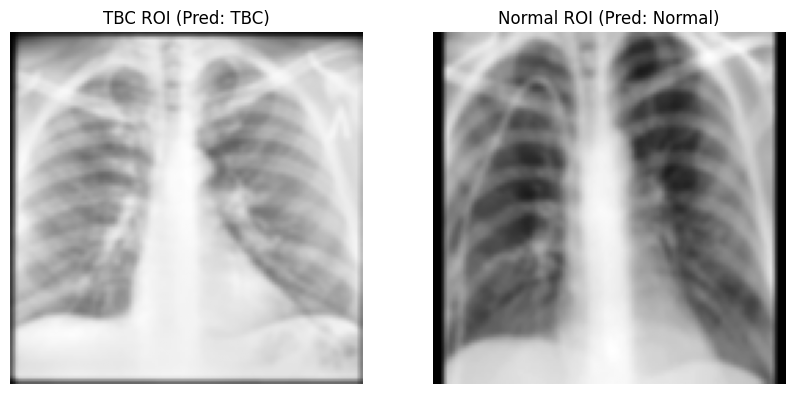

In [75]:
def test_dual_roi(tbc_img, tbc_mask, normal_img, normal_mask):
    tbc_roi    = stage4_apply_mask(tbc_img, tbc_mask)
    normal_roi = stage4_apply_mask(normal_img, normal_mask)

    # Prediksi masing-masing
    tbc_pred, tbc_proba = predict_image_with_roi(tbc_img, tbc_mask)
    normal_pred, normal_proba = predict_image_with_roi(normal_img, normal_mask)

    # Tampilkan berdampingan
    show_pair(
        tbc_roi, normal_roi,
        f"TBC ROI (Pred: {'TBC' if tbc_pred==1 else 'Normal'})",
        f"Normal ROI (Pred: {'TBC' if normal_pred==1 else 'Normal'})"
    )

test_dual_roi(
    tbc_enhanced,
    tbc_final,
    normal_enhanced,
    normal_final
)
